# #451 Concrete Half Joint
<i>Nonlinear concrete cracking model with parasitic bars modelling a concrete half joint</i>
***

![Preview](../../_img/jupyter_notebook_451.png)
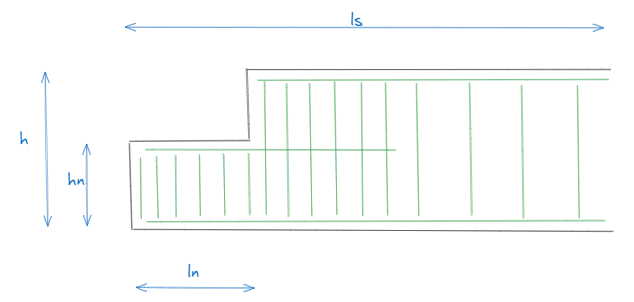

In [ ]:
ls = 2500 # mm
h  = 1000 # mm
hn = 500  # mm
ln = 500  # mm
cov = 50  # mm
mesh_size = h/5 # Ratio of height
section_width = 1000 #mm
load = 250_000 #N

link_spacings1 = [50] + 4*[100]
link_spacings2 = [50] + 3*[100] + 5*[150] + 3*[250]

link_diameter = 10 #mm
main_bar_diameter = 25 #mm

transverse_bar_spacing = 150 #mm
bar_ratio = section_width/transverse_bar_spacing

# See materials section for material inputs

#### Connect to LUSAS and create a new model database

In [ ]:
import sys; sys.path.append('../') # Reference modules in parent directory
from shared.LPI_21_1 import *
lusas = get_lusas_modeller()

import shared.Helpers as Helpers
Helpers.initialise(lusas)

if lusas.existsDatabase() and lusas.db().isModified():
    raise Exception("This script will create a new model. Please save or close the current model and try again")

# Create a new model
lusas.newProject("Structural", "Half joint.mdl")
 # Reference to the model database for convenience
db = lusas.database()
# Set model database options
db.setAnalysisCategory("2D Inplane")
db.setModelUnits("N,mm,t,s,C")
db.setTimescaleUnits("Days")


### Create the concrete geometry

In [ ]:
geometry_data = lusas.geometryData().setAllDefaults()
geometry_data.addCoords(0.0, 0.0, 0.0)
geometry_data.addCoords(ln, 0.0, 0.0)
geometry_data.addCoords(ln, hn, 0.0)
geometry_data.addCoords(0.0, hn, 0.0)
geometry_data.setLowerOrderGeometryType("coordinates")
surface1 = win32.CastTo( db.createSurface(geometry_data).getObject("Surface") , "IFSurface")

geometry_data = lusas.geometryData().setAllDefaults()
geometry_data.addCoords(ln, 0.0, 0.0)
geometry_data.addCoords(ls, 0.0, 0.0)
geometry_data.addCoords(ls, hn, 0.0)
geometry_data.addCoords(ln, hn, 0.0)
geometry_data.setLowerOrderGeometryType("coordinates")
surface2 = win32.CastTo( db.createSurface(geometry_data).getObject("Surface") , "IFSurface")

geometry_data = lusas.geometryData().setAllDefaults()
geometry_data.addCoords(ln, hn, 0.0)
geometry_data.addCoords(ls, hn, 0.0)
geometry_data.addCoords(ls, h, 0.0)
geometry_data.addCoords(ln, h, 0.0)
geometry_data.setLowerOrderGeometryType("coordinates")
surface3 = win32.CastTo( db.createSurface(geometry_data).getObject("Surface") , "IFSurface")

In [ ]:
# Get the lines to which we'll assign supports at the far right end
support_lines = []
for surface in [surface2, surface3]:
    for line in surface.getBoundaryLOFs(0):
        if line.getStartPoint().getX() > 0.99*ls and \
           line.getEndPoint().getX() > 0.99*ls:
            support_lines.append(line)

# Get the line to which we'll assign loads at the upper face of the cut-out
load_lines = []
for line in surface1.getBoundaryLOFs(0):
    if line.getStartPoint().getY() > 0.99*hn and \
        line.getEndPoint().getY() > 0.99*hn:
        load_lines.append(line)

In [ ]:
# Create and assign a thickness for the surfaces
surface_thickness_attr = db.createGeometricSurface("Surface thickness").setSurface(section_width, 0.0)
surface_thickness_attr.assignTo("Surface")

### Create reinforcement geometry

In [ ]:
link_lines = []

x = 0
for spacing in link_spacings1:
    x+=spacing
    link_lines.append(Helpers.create_line([x, cov, 0], [x, hn-cov, 0]))

x = ln
for spacing in link_spacings2:
    x+=spacing
    link_lines.append(Helpers.create_line([x, cov, 0], [x, h-cov, 0]))

main_bar_lines = []
main_bar_lines.append(Helpers.create_line([cov, cov,0], [ls, cov, 0]))
main_bar_lines.append(Helpers.create_line([cov, hn-cov,0], [ls/2, hn-cov, 0]))
main_bar_lines.append(Helpers.create_line([ln+cov, h-cov,0], [ls, h-cov, 0]))

# Mesh Attributes

In [ ]:
# Create a plane stress mesh attribute and assign it to the surfaces
attr = db.createMeshSurface("Plane Stress")
attr.setRegularSize("QPM4M", mesh_size, True)
attr.setValue("allowIrregular", True)
attr.assignTo("Surfaces", lusas.assign().setAllDefaults())

# Create parasitic bar element mesh
bar_mesh_attr = db.createMeshLine("Bar Mesh")
bar_mesh_attr.addElementName("BAR2")
bar_mesh_attr.setParasiticType("reinforcement", "allow gaps")
bar_mesh_attr.removeParasiticSpacing()
bar_mesh_attr.setParasiticMaxPercentDeviation(10.0)
bar_mesh_attr.setValue("uiSpacing", "uniform")
# Assign to the line geometry
bar_mesh_attr.assignTo(link_lines)
bar_mesh_attr.assignTo(main_bar_lines)

db.updateMesh()

### Define the reinforcement

In [ ]:
# Helper function to create geometric attributes for reinforcing bars
bar_names = Helpers.create_reinforcing_bar_attributes(db, [link_diameter, main_bar_diameter])

# Modification factors to increase the stiffness of the bars to the number they represent
stiffness_mod_bars_150 = db.createSectionPropertyModifier(f"Bars at {transverse_bar_spacing}mm")
stiffness_mod_bars_150.setMassFactor("A", bar_ratio)
stiffness_mod_bars_150.setStiffnessFactor("A", bar_ratio)
stiffness_mod_bars_150.setStiffnessFactor("Izz", bar_ratio)
stiffness_mod_bars_150.setStiffnessFactor("Asy", bar_ratio)

# Assign geometric attributes to links
geom_attr = db.getAttribute("Geometric", bar_names[0])
geom_attr.assignTo(link_lines)
stiffness_mod_bars_150.assignTo(link_lines)

# Assign geometric attributes to main bars
geom_attr = db.getAttribute("Geometric", bar_names[1])
geom_attr.assignTo(main_bar_lines)
stiffness_mod_bars_150.assignTo(link_lines)

# Materials

In [ ]:
# Elastic material for the bars
rebar_material_attr = db.createIsotropicMaterial("Reinforcing Steel", 200.0E3, 0.3, 7.85e-9, 12e-6)
rebar_material_attr.assignTo(link_lines)
rebar_material_attr.assignTo(main_bar_lines)

In [ ]:
# Non-linear concrete material
non_linear_concrete = db.createIsotropicMaterial("Nonlinear Concrete", 36.75E3, 0.2, 2.5484e-9, 10e-6)
if lusas.getMajorVersionNumber() > 21:
    non_linear_concrete.addPlasticConcrete109(48.0, 3.5, 2.2E-3, 0.0, 0.13, 
                                            1.15, 0.6, -0.1, 0.425, 0.5, 5.0, 1.25, 0.8, 
                                            0.05, 0.06, 0.03, 0.6, 0.75, 8.0, 8.0, 3.0, 2, 2, 0.0, "fracture")
else:
    non_linear_concrete.addPlasticConcrete109(48.0, 3.5, 2.2E-3, 0.0, 0.13, 
                                            1.15, 0.6, -0.1, 0.3, 0.5, 5.0, 1.25, 0.8, 
                                            0.05, 0.06, 0.03, 0.6, 0.75, 8.0, 8.0, 3.0, 2, 2, 0.0)

non_linear_concrete.assignTo("Surfaces")

### Support Conditions

In [ ]:
support_attr = db.createSupportStructural("Fixed")
support_attr.setStructural("R", "R", "F", "F", "F", "F", "F", "F", "C", "F")
support_attr.assignTo(support_lines)

### Loading

In [ ]:
load_attr = db.createLoadingGlobalDistributed("Load")
load_attr.setGlobalDistributed("Total", 0.0, -load, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, False, 0.0)
load_attr.assignTo(load_lines)

In [ ]:
# Set a nonlinear analysis for loadcase 1
loadcase = win32.CastTo(db.getLoadset(1), "IFLoadcase")
nl_control = loadcase.setTransientControl(0).getTransientControl()
nl_control.setNonlinearAutomatic(0.1).setOutput().setConstants()
nl_control.setValue("MaxLoadFactor", 2.0)

Set the display properties

In [ ]:
lusas.view().setScaledToFit(True)
lusas.view().insertContoursLayer()
lusas.view().contours().setResultsTransformNone()
lusas.view().contours().setResults("Stress - Bar", "Sx(Fx)")
lusas.view().contours().setDisplayType("Internal")
lusas.view().insertValuesLayer()
lusas.view().values().setResultsTransformNone()
lusas.view().values().setResults("Stress - Bar", "Sx(Fx)")